In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

sub_size = 20
X_size = 1000

X_star = np.linspace(0, 1, X_size)
X = X_star.reshape(-1,1)
# Evenly sample X_size points from sub_size points
sorted_indices = np.linspace(0, X_size-1, sub_size, dtype=int)

X_sub = X[sorted_indices]
def RBF_kernel(X, Y, sigma2):
    X = np.array(X)
    Y = np.array(Y)
    mat1 = np.sum(X**2, 1).reshape(-1, 1)
    mat2 = np.sum(Y**2, 1)
    mat = mat1 + mat2 - 2 * np.dot(X, Y.T)
    mat = np.exp(-0.5 / sigma2 * mat)
    return mat

kTup = 1 # Hyperparameter： sigma squared
K = RBF_kernel(X_sub, X_sub, kTup)   # Kernel Matrix of Fixed-Size Support Vectors

eigenvalue, featurevector = np.linalg.eig(K)      #Eigenvalue Decomposition of Kernel Matrix
A = eigenvalue             
B = featurevector

KK = RBF_kernel(X, X_sub, kTup)    # Kernel Matrix Generated from the Total Sample Set and Subsample Sets
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                                 # Primal form of the Sample Set Feature Function

X_F_1 = X_F[0,:]
X_F_1 = X_F_1.reshape(1, sub_size)

eigenvalue, featurevector = np.linalg.eig(K)     
A = eigenvalue             
B = featurevector
KK = RBF_kernel(X, X_sub, kTup)   
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                                

X_F_N = X_F[-1,:]
X_F_N = X_F_N.reshape(1, sub_size)

X = X_star
X = X.reshape(-1,1)
X = X[1:-1]
KK = RBF_kernel(X, X_sub, kTup)    

X_diag = np.diag(X.flatten())  
X_sub_diag = np.diag(X_sub.flatten())  
KK_D = ( KK @ X_sub_diag - X_diag @ KK ) / (kTup)  # First-order derivative of the kernel function

eigenvalue, featurevector = np.linalg.eig(K)      
A = eigenvalue             
B = featurevector
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F = K_1 @ A_lam
X_F = F                        

eigenvalue, featurevector = np.linalg.eig(K)     
A = eigenvalue             
B = featurevector
K_1 = KK_D @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F_D = K_1 @ A_lam
X_F_D = F_D                    # First-Order Derivative of the Sample Set Feature Function           

X = X_star
X = X.reshape(-1,1)
X = X[1:-1]
KK = RBF_kernel(X, X_sub, kTup)  

X_diag_squa = np.square(X_diag)
X_sub_diag_squa = np.square(X_sub_diag)

# Second-order derivative of the kernel function
KK_DD = KK/(-kTup) + ( KK @ X_sub_diag_squa -  2 * X_diag @ KK @ X_sub_diag  + X_diag_squa @ KK ) / (kTup) 

eigenvalue, featurevector = np.linalg.eig(K) 
A = eigenvalue             
B = featurevector
K_1 = KK_DD @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)

F_DD = K_1 @ A_lam
X_F_DD = F_DD                               # Second-Order Derivative of the Sample Set Feature Function

gamma = 10000000  #Hyperparameter: gamma

# Differential equation parameters
r = np.full((X_size-2, 1), 2)
p1 = 1
p2 = 0
E = np.eye(sub_size)
I = np.ones((X_size-2, 1))
f1 = 0
f2 = -1

A = (gamma * (X_F_DD - f1 * X_F_D - f2 * X_F)).T
B = (-1 * gamma * f2 * I).T

print(A.shape)
print(B.shape)
zero = np.zeros((sub_size, 1))

# Construct the matrix equation and solve it.
X11 = E + A @ (X_F_DD - f1 * X_F_D - f2 * X_F)
X12 = -1 * f2 * A @ I
X13 = X_F_1.T
X14 = X_F_N.T
X1 = np.hstack((X11, X12, X13, X14))

X21 = B @ (X_F_DD - f1 * X_F_D - f2 * X_F)
X22 = -1 * f2 * B @ I
X23 = (np.array([1])).reshape(1, 1)
X24 = (np.array([1])).reshape(1, 1)
X2 = np.hstack((X21, X22, X23, X24))

X31 = X_F_1
X32 = (np.array([1])).reshape(1, 1)
X33 = (np.array([0])).reshape(1, 1)
X34 = (np.array([0])).reshape(1, 1)
X3 = np.hstack((X31, X32, X33, X34))

X41 = X_F_N
X42 = (np.array([1])).reshape(1, 1)
X43 = (np.array([0])).reshape(1, 1)
X44 = (np.array([0])).reshape(1, 1)
X4  = np.hstack((X41, X42, X43, X44))

X_solve = np.vstack((X1, X2, X3, X4))

Y1 = A @ r   
Y2 = B @ r 
Y3 = (np.array([p1])).reshape(1, 1)
Y4 = (np.array([p2])).reshape(1, 1)

Y_solve = np.vstack((Y1, Y2, Y3,Y4))
W_lam_b = np.linalg.solve(X_solve, Y_solve)

#Calculate the prediction results
X = X_star
X = X.reshape(-1,1)
KK = RBF_kernel(X, X_sub, kTup)    
eigenvalue, featurevector = np.linalg.eig(K)    
A = eigenvalue             
B = featurevector
K_1 = KK @ B
A = np.sqrt(A)
A = np.reciprocal(A)
A = A * np.sqrt(sub_size)
A1 = A.flatten()
A_lam = np.diag(A1)
F = K_1 @ A_lam
X_F = F                                

W = W_lam_b[:sub_size, :]
b = W_lam_b[-3]

y_p =  np.real(np.dot(X_F,W) + b.item())

(20, 998)
(1, 998)


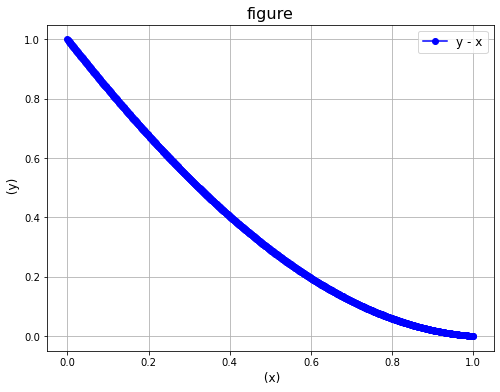

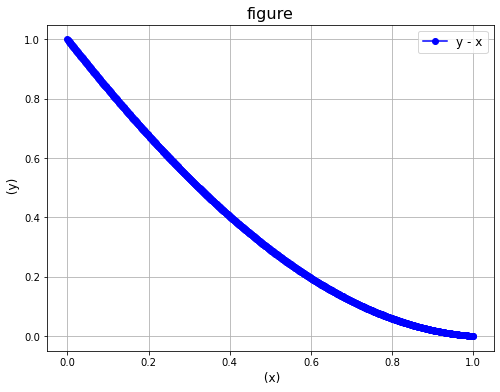

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x = X 
a = y_p
y = y_p             
plt.figure(figsize=(8, 6))
plt.plot(x, y, label="y - x", color="blue", linestyle="-", marker="o")
plt.title("figure", fontsize=16)
plt.xlabel(" (x)", fontsize=12)
plt.ylabel(" (y)", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


x = X 
y_t =  -np.cos(x) + (np.cos(1) - 2 )* np.sin(x) / np.sin(1) + 2
y_t = np.array(y_t)
b = y_t
y = y_t              
plt.figure(figsize=(8, 6)) 
plt.plot(x, y, label="y - x", color="blue", linestyle="-", marker="o")
plt.title("figure", fontsize=16)
plt.xlabel(" (x)", fontsize=12)
plt.ylabel(" (y)", fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

In [3]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

y_p_fsvm = a
y_true = b
R2_fsvm = r2_score(y_p_fsvm, y_true.reshape(-1, 1))
mae_fsvm = mean_absolute_error(y_p_fsvm, y_true.reshape(-1, 1))
rmse_fsvm = mean_squared_error(y_p_fsvm, y_true.reshape(-1, 1), squared = False)
inf_norm_fsvm = np.linalg.norm(y_p_fsvm - y_true.reshape(-1, 1), ord = np.inf)

print(f"R2_fsvm: {R2_fsvm}, mae_fsvm: {mae_fsvm}, rmse_fsvm: {rmse_fsvm}, inf_norm_fsvm: {inf_norm_fsvm}") 


import pandas as pd

data_to_save = pd.DataFrame({
    'y_pred_fsvm': y_p_fsvm.flatten()
})
data_to_save.to_csv('fsvm_12.csv', index=False)
print(" fsvm_12.csv")

R2_fsvm: 0.9999999999999998, mae_fsvm: 3.154082985457052e-09, rmse_fsvm: 3.940887708849492e-09, inf_norm_fsvm: 1.309671304738913e-08
数据已保存至 fsvm_12.csv
